In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import sys
sys.path.append('./src/baybe_utils')
from run_grid_experiments_baybe import run_grid_experiments
from run_grid_experiments_baybe_random import run_grid_experiments_random
from src import visualization
import numpy as np
import matplotlib.pyplot as plt

from src import schwefel

/home/brendenpelkie/miniconda3/envs/noisybo/lib/python3.12/site-packages/baybe/telemetry.py:222: UserWarning: WARNING: BayBE Telemetry endpoint https://public.telemetry.baybe.p.uptimize.merckgroup.com:4317 cannot be reached. Disabling telemetry. The exception encountered was: ConnectionError, HTTPConnectionPool(host='verkehrsnachrichten.merck.de', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7f6d19881010>: Failed to resolve 'verkehrsnachrichten.merck.de' ([Errno -2] Name or service not known)"))
  warnings.warn(


SMOKE_TEST None
SMOKE_TEST None


## Intro

This work lightly explores the impact of a noisy oracle on Bayesian optimization performance. Here, the 2-dimensional Schwefel function with Gaussian noise is used as an optimization objective. However, this work is motivated by the need to deal with noisy data when applying BO to experimental optimization. 

## Implementation Notes

- This work was done as an entry in the 2024 Bayesian optimization for materials hackathon
- Our team pursued multiple implementations in parallel
- This notebook serves as an entry point to the BayBE implementation of the project
- Individual optimization campaigns are run from the run_experiments() function in run_experiment_babye.py
- Grid screening of parameters builds on this with funcitonality in the run_grid_experiments_babye.py
- As this was a hackathon project, there are some hacks. Watch out for hard-coded gotchas throughout. Would not recommend directly re-using code. 

## 1. Define grid search parameters 

This is to run a grid search over experiment parameters like number of BO trials to run, noise level, etc. These values were chosen by the team as 'reasonable' sounding values.

In [5]:
seeds = list(range(5)) # run 5 replicates of each parameter set
n_inits = [2, 4, 8, 10] # Number of initial randomly collected data points
noise_levels = [1, 5, 10, 20] # variance (?) of gaussian noise. Bigger number -> more noise
noise_bools = [True] # carryover from BoTorch side of project, ignore
budget = 30 # Run 30 iterations of BO
bounds = (0, 500)

## 2. Run grid search

Run the grid search over parameters. This will take a minute or 60. Results are written to disk so if you are just following along, skip this step and load below 

In [5]:
run_grid_experiments(seeds, n_inits, noise_levels, noise_bools, budget, bounds)

Beginning optimization campaign
Started problem 2 noise 1 budget 30 seed 0, time: 9.77s
Beginning optimization campaign
Started problem 2 noise 5 budget 30 seed 0, time: 20.17s
Beginning optimization campaign
Started problem 2 noise 10 budget 30 seed 0, time: 29.14s
Beginning optimization campaign
Started problem 2 noise 20 budget 30 seed 0, time: 37.97s
Beginning optimization campaign
Started problem 4 noise 1 budget 30 seed 0, time: 46.36s
Beginning optimization campaign
Started problem 4 noise 5 budget 30 seed 0, time: 53.80s
Beginning optimization campaign
Started problem 4 noise 10 budget 30 seed 0, time: 63.23s
Beginning optimization campaign
Started problem 4 noise 20 budget 30 seed 0, time: 73.00s
Beginning optimization campaign
Started problem 8 noise 1 budget 30 seed 0, time: 82.27s
Beginning optimization campaign
Started problem 8 noise 5 budget 30 seed 0, time: 92.22s
Beginning optimization campaign
Started problem 8 noise 10 budget 30 seed 0, time: 101.83s
Beginning optimi

### Run random search as well

Generate some random baseline data to compare against


In [6]:
run_grid_experiments_random(seeds, n_inits, noise_levels, noise_bools, budget, bounds)

Started problem 2 noise 1 budget 30 seed 0, time: 0.97s
Started problem 2 noise 5 budget 30 seed 0, time: 1.90s
Started problem 2 noise 10 budget 30 seed 0, time: 2.83s
Started problem 2 noise 20 budget 30 seed 0, time: 3.75s
Started problem 4 noise 1 budget 30 seed 0, time: 4.67s
Started problem 4 noise 5 budget 30 seed 0, time: 5.60s
Started problem 4 noise 10 budget 30 seed 0, time: 6.52s
Started problem 4 noise 20 budget 30 seed 0, time: 7.44s
Started problem 8 noise 1 budget 30 seed 0, time: 8.38s
Started problem 8 noise 5 budget 30 seed 0, time: 9.32s
Started problem 8 noise 10 budget 30 seed 0, time: 10.27s
Started problem 8 noise 20 budget 30 seed 0, time: 11.24s
Started problem 10 noise 1 budget 30 seed 0, time: 12.23s
Started problem 10 noise 5 budget 30 seed 0, time: 13.18s
Started problem 10 noise 10 budget 30 seed 0, time: 14.14s
Started problem 10 noise 20 budget 30 seed 0, time: 15.09s
Started problem 2 noise 1 budget 30 seed 1, time: 16.02s
Started problem 2 noise 5 bud

## 3. Process Results

In [52]:
global_min = torch.tensor([420,420])

In [66]:
# load BO results 
sm_list_bo = {}
sm_x_list_bo = {}
bo_results = pd.DataFrame(columns=["n_init", "noise_level", "seed", "noise_bool", "best"])
for noise_bool in noise_bools:
    for n_init in n_inits:
        for noise_level in noise_levels:
            sm_agg = torch.zeros((len(seeds), n_init+budget))
            for idx, seed in enumerate(seeds):
                X, Y, Y_real, model = torch.load(f"results_baybe_extendedBounds/results_baybe/Schwe_n_init_{n_init}_noiselvl_{noise_level}_budget_{budget}_seed_{seed}_noise_{noise_bool}.pt")
                sliding_min = torch.zeros(Y.shape[0])
                sliding_x_min = torch.zeros(Y.shape[0])
                for i in range(Y_real.shape[0]):
                    sliding_min[i] = Y_real[:i+1].min().item()
                    min_x = X[Y_real[:i+1].argmin().item()]
                    x_rmsd = np.sqrt((min_x[0].item() - global_min[0].item())** 2 + (min_x[1].item() -global_min[1].item())**2)
                    sliding_x_min[i] = x_rmsd
                
                sm_agg[idx] = sliding_min
                sm = pd.Series(sliding_min.numpy())
                
                bo_results = pd.concat([bo_results, pd.DataFrame({"n_init": [n_init], "noise_level": [noise_level], "seed": [seed], "noise_bool": [noise_bool],
                                                  "best": [sliding_min[-1].item()]})])
                
            sm_mean = sm_agg.mean(0)
            sm_std = sm_agg.std(0)
            sm_list_bo[(n_init, noise_level, noise_bool)] = (sm_mean, sm_std)
            sm_x_list_bo[(n_init, noise_level, noise_bool)] = sliding_x_min
bo_results  

/tmp/ipykernel_22503/1164103272.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bo_results = pd.concat([bo_results, pd.DataFrame({"n_init": [n_init], "noise_level": [noise_level], "seed": [seed], "noise_bool": [noise_bool],


,n_init,noise_level,seed,noise_bool,best
0,2,1,0,True,219.849106
0,2,1,1,True,23.180445
0,2,1,2,True,0.325259
0,2,1,3,True,234.490707
0,2,1,4,True,0.764173
...,...,...,...,...,...
0,10,20,0,True,0.684985
0,10,20,1,True,1.410233
0,10,20,2,True,0.926888
0,10,20,3,True,2.214593


In [67]:
# load random results 
sm_list_random = {}
sm_x_list_random = {}
random_results = pd.DataFrame(columns=["n_init", "noise_level", "seed", "noise_bool", "best"])
for noise_bool in noise_bools:
    for n_init in n_inits:
        for noise_level in noise_levels:
            sm_agg = torch.zeros((len(seeds), n_init+budget))
            for idx, seed in enumerate(seeds):
                X, Y, Y_real, model = torch.load(f"results_baybe_extendedBounds/results_random_baybe/Schwe_n_init_{n_init}_noiselvl_{noise_level}_budget_{budget}_seed_{seed}_noise_{noise_bool}.pt")
                #print(torch.min(Y_real))
                sliding_min = torch.zeros(Y.shape[0])
                for i in range(Y_real.shape[0]):
                    sliding_min[i] = Y_real[:i+1].min().item()
                    min_x = X[Y_real[:i+1].argmin().item()]
                    x_rmsd = np.sqrt((min_x[0].item() - global_min[0].item())** 2 + (min_x[1].item() -global_min[1].item())**2)
                    sliding_x_min[i] = x_rmsd
                
                sm_agg[idx] = sliding_min
                sm = pd.Series(sliding_min.numpy())
                
                random_results = pd.concat([random_results, pd.DataFrame({"n_init": [n_init], "noise_level": [noise_level], "seed": [seed], "noise_bool": [noise_bool],
                                                  "best": [sliding_min[-1].item()]})])

                #print(sliding_min)

            
            sm_mean = sm_agg.mean(0)
            sm_std = sm_agg.std(0)
            sm_list_random[(n_init, noise_level, noise_bool)] = (sm_mean, sm_std)
            sm_x_list_random[(n_init, noise_level, noise_bool)] = sliding_x_min
random_results  

/tmp/ipykernel_22503/129970788.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  random_results = pd.concat([random_results, pd.DataFrame({"n_init": [n_init], "noise_level": [noise_level], "seed": [seed], "noise_bool": [noise_bool],


,n_init,noise_level,seed,noise_bool,best
0,2,1,0,True,382.194916
0,2,1,1,True,12.435197
0,2,1,2,True,295.999420
0,2,1,3,True,2.214593
0,2,1,4,True,176.200272
...,...,...,...,...,...
0,10,20,0,True,382.194916
0,10,20,1,True,12.435197
0,10,20,2,True,295.999420
0,10,20,3,True,2.214593


Calculate 'performance matrix' to generate iterations vs noise heat map

In [73]:
performance_matrix_bo = np.zeros((len(n_inits), len(noise_levels)))

for i, init in enumerate(n_inits):
    for j, noise in enumerate(noise_levels):
        y_vals = torch.load(f'results_baybe_extendedBounds/results_baybe/Schwe_n_init_{init}_noiselvl_{noise}_budget_30_seed_0_noise_True.pt')[2]
        best_y = torch.min(y_vals)
        performance_matrix_bo[i,j] = best_y
        

In [74]:
performance_matrix_random = np.zeros((len(n_inits), len(noise_levels)))

for i, init in enumerate(n_inits):
    for j, noise in enumerate(noise_levels):
        y_vals = torch.load(f'results_baybe_extendedBounds/results_random_baybe/Schwe_n_init_{init}_noiselvl_{noise}_budget_30_seed_0_noise_True.pt')[2]
        best_y = torch.min(y_vals)
        performance_matrix_random[i,j] = best_y

## 4. Plot

### backtesting plots

1. Fix n_init, compare noise level

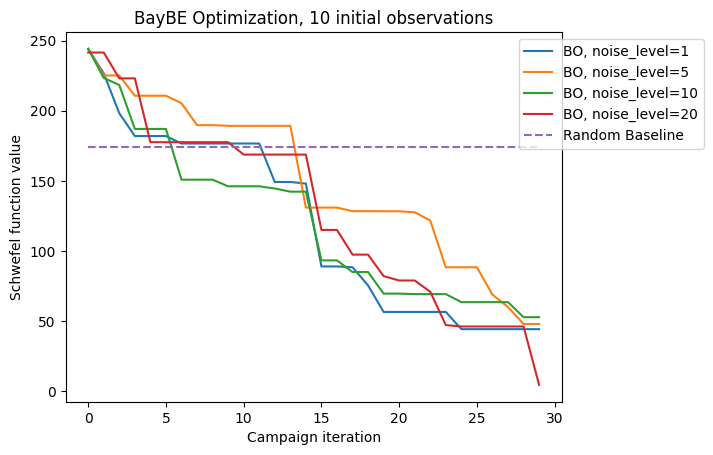

In [48]:
n_init_val = 10
#df_bo = bo_results.groupby(["n_init", "noise_level"]).agg({"best": ["mean", "std"]})
#df_rand = random_results.groupby(["n_init", "noise_level"]).agg({"best": ["mean", "std"]})

# we already got the statistics from all seeds above, but only want to plot one example for each so just pick first seed 
plot_bo = bo_results[bo_results['seed'] == 0]
plot_rand = random_results[random_results['seed'] == 0]

fig, ax = plt.subplots()

for idx, row in plot_bo.iterrows():
    if row['n_init'] == n_init_val:
        mean = sm_list_bo[(n_init_val, row['noise_level'], True)][0][n_init_val:]
        std = sm_list_bo[(n_init_val, row['noise_level'], True)][1][n_init_val:]
        plt.plot(mean, label=f"BO, noise_level={row['noise_level']}")
        #plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.1)
    
for idx, row in plot_rand.iterrows():
    if row['n_init'] == n_init_val:
        mean = sm_list_random[(n_init_val, row['noise_level'], True)][0][n_init_val:]
        std = sm_list_random[(n_init_val, row['noise_level'], True)][1][n_init_val:]
        plt.plot(mean, label=f"Random Baseline", linestyle="--")
        break
        #plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.1)

# aaawaaay
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title(f"BayBE Optimization, {n_init_val} initial observations")

ax.set_xlabel('Campaign iteration')
ax.set_ylabel('Schwefel function value')
plt.show()


Note: The random baseline is a flatline because the random search finds the best point at the 10th iteration with our seeds, which is not shown here because it falls within the initial random data collection phase. 

2. Fix noise value, compare initial data number

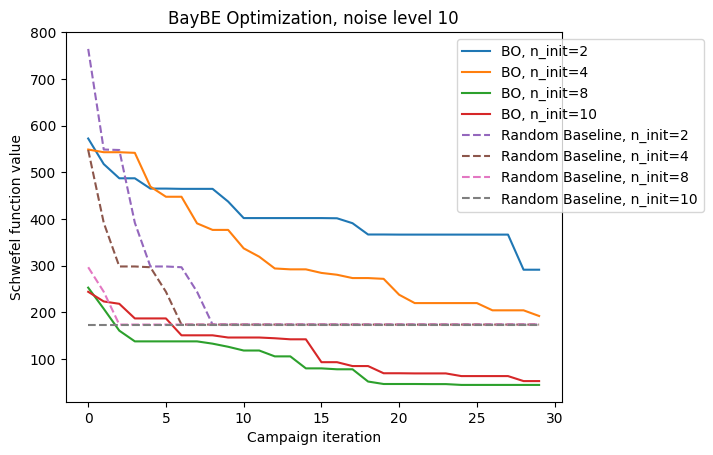

In [51]:
noise_level_val = 10
#df_bo = bo_results.groupby(["n_init", "noise_level"]).agg({"best": ["mean", "std"]})
#df_rand = random_results.groupby(["n_init", "noise_level"]).agg({"best": ["mean", "std"]})

# we already got the statistics from all seeds above, but only want to plot one example for each so just pick first seed 
plot_bo = bo_results[bo_results['seed'] == 0]
plot_rand = random_results[random_results['seed'] == 0]

fig, ax = plt.subplots()

for idx, row in plot_bo.iterrows():
    if row['noise_level'] == noise_level_val:
        n_init_val = row['n_init']
        mean = sm_list_bo[(row['n_init'], noise_level_val, True)][0][n_init_val:]
        std = sm_list_bo[(row['n_init'], noise_level_val, True)][1][n_init_val:]
        plt.plot(mean, label=f"BO, n_init={row['n_init']}")
        #plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.1)
    
for idx, row in plot_rand.iterrows():
    if row['noise_level'] == noise_level_val:
        n_init_val = row['n_init']
        mean = sm_list_random[(row['n_init'], noise_level_val, True)][0][n_init_val:]
        std = sm_list_random[(row['n_init'], noise_level_val, True)][1][n_init_val:]
        plt.plot(mean, label=f"Random Baseline, n_init={row['n_init']}", linestyle="--")
        #plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.1)
        #break

# aaawaaay
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title(f"BayBE Optimization, noise level {noise_level_val}")

ax.set_xlabel('Campaign iteration')
ax.set_ylabel('Schwefel function value')
plt.show()

### Heat map plot

Text(0.5, 1.0, 'Bayesian Optimization')

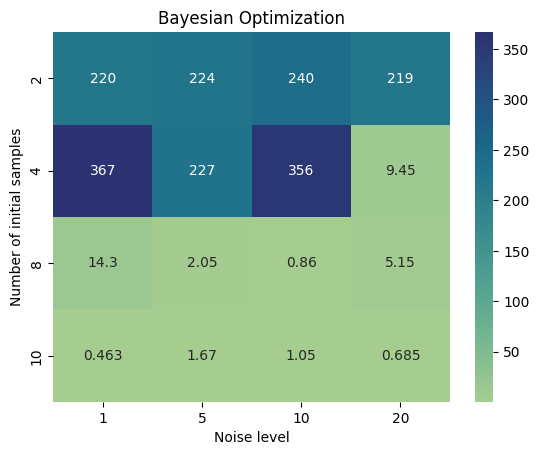

In [75]:

fig, ax = plt.subplots()
visualization.grid_search_heatmap(n_inits, noise_levels, performance_matrix_bo)

ax.set_title('Bayesian Optimization')

Text(0.5, 1.0, 'Random')

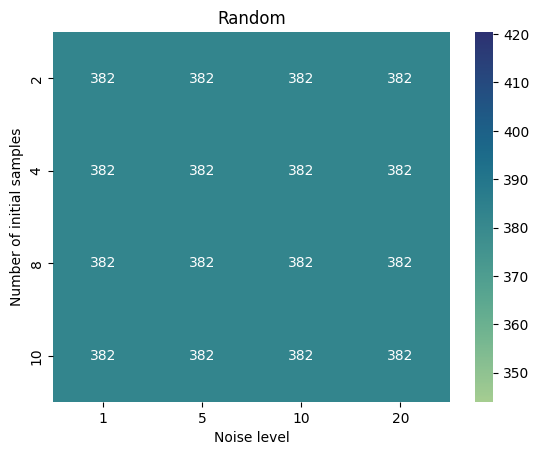

In [76]:
fig, ax = plt.subplots()
visualization.grid_search_heatmap(n_inits, noise_levels, performance_matrix_random)
ax.set_title('Random')

## 'X-distance' plot
This plot looks at the distance from the true global minimum of the best point found so far in the optization. Unlike the 'best point found' backtesting plots above, the values do fluctuate up and down as a new 'best' local minimum that is found could be further from the global minimum. It looks like most BO schemes are settling into local minima that are not close to the global minimum, while high-noise BO and random baseline seem to have gotten lucky and found the global minima early. 

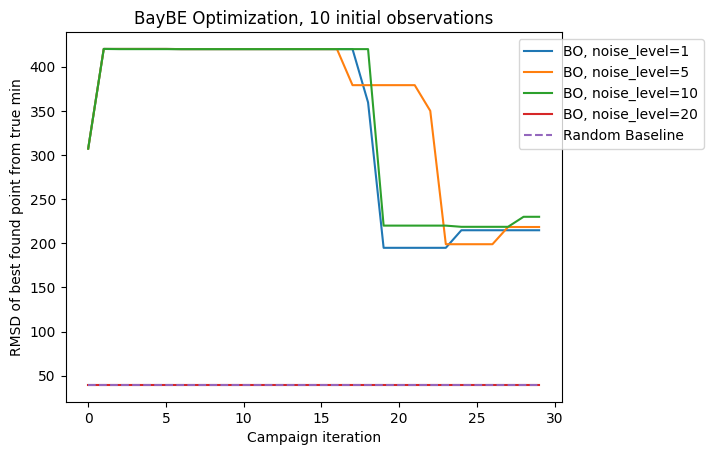

In [72]:
# plot distance of best point from global min

n_init_val = 10
#df_bo = bo_results.groupby(["n_init", "noise_level"]).agg({"best": ["mean", "std"]})
#df_rand = random_results.groupby(["n_init", "noise_level"]).agg({"best": ["mean", "std"]})

# we already got the statistics from all seeds above, but only want to plot one example for each so just pick first seed 
plot_bo = bo_results[bo_results['seed'] == 0]
plot_rand = random_results[random_results['seed'] == 0]

fig, ax = plt.subplots()

for idx, row in plot_bo.iterrows():
    if row['n_init'] == n_init_val:
        mean = sm_x_list_bo[(n_init_val, row['noise_level'], True)][n_init_val:]
        #std = sm_x_list_bo[(n_init_val, row['noise_level'], True)][1][n_init_val:]
        plt.plot(mean, label=f"BO, noise_level={row['noise_level']}")
        #plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.1)
    
for idx, row in plot_rand.iterrows():
    if row['n_init'] == n_init_val:
        mean = sm_x_list_random[(n_init_val, row['noise_level'], True)][n_init_val:]
        #std = sm_x_list_random[(n_init_val, row['noise_level'], True)][1][n_init_val:]
        plt.plot(mean, label=f"Random Baseline", linestyle="--")
        break
        #plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.1)

# aaawaaay
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title(f"BayBE Optimization, {n_init_val} initial observations")

ax.set_xlabel('Campaign iteration')
ax.set_ylabel('RMSD of best found point from true min')
plt.show()